In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter

from time import time

%matplotlib inline

import scipy.sparse

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('axes', labelsize='large') 

In [3]:
def id_counter(id_list):
    cnt = Counter()
    for el in id_list:
        cnt[el[u'element']] = el[u'count']
    return cnt

def_black_list = { 'unit', 'units', 'value', 'values', 'axis', 'axes', 'factor', 'factors', 'line', 'lines',
                 'point', 'points', 'number', 'numbers', 'variable', 'variables', 'respect', 'case', 'cases',
                 'vector', 'vectors', 'element', 'elements', 'example', 'index', 'indices',
                 'integer', 'integers', 'term', 'terms', 'parameter', 'parameters', 'coefficient', 'coefficients',
                 'formula', 'times', 'product', 'matrices', 'expression', 'complex', 'real', 'zeros', 'bits',
                 'sign', 'radian/s',
                 'if and only if',
                 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 
                 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'}

def valid_def(definition):
    if len(definition) <= 3:
        return False

    return definition.lower() not in def_black_list

def rel_to_dict(rels):
    res = defaultdict(list)
    for r in rels:
        if not valid_def(r['definition']):
            continue
        res[r['identifier']].append((r['definition'], r['score']))
    return res

In [4]:
from collections import defaultdict

doc_categories = defaultdict(set)
category_docs = defaultdict(set)

for line in file('C:/tmp/mlp/category_info_refined.txt'):
    title, cat = line.strip().split('\t')
    title = title.decode('utf-8')
    cat = cat.decode('utf-8')

    # let's also remove all documents from "OTHER" category
    if cat == u'OTHER':
        continue

    doc_categories[title].add(cat) 
    category_docs[cat].add(title)

In [5]:
root = 'C:/tmp/mlp/mlp-output/'

docs = []
titles = []
ids = []
rels = []

empty = 0
small = 0
uncategorized = 0

for f in os.listdir(root): 
    for line in file(root + f):
        doc = json.loads(line)

        title = doc['title']        
        if title not in doc_categories:
            uncategorized = uncategorized + 1
            continue

        if '(disambiguation)' in title:
            continue

        id_bag = id_counter(doc['identifiers'])
        if len(id_bag) <= 1:
            if len(id_bag) == 0:
                empty = empty + 1
            else:
                small = small + 1
            continue

        docs.append(doc)
        titles.append(title)
        ids.append(id_bag)

        id_rels = rel_to_dict(doc['relations'])
        rels.append(id_rels)

print empty, small, uncategorized

N_doc = len(ids)
print N_doc

0 0 7501
22512


In [6]:
title_idx = {title: idx for (idx, title) in enumerate(titles)}

for doc, cats in doc_categories.items():
    if doc in title_idx:
        continue

    for cat in cats: 
        category_docs[cat].remove(doc)
    
    del doc_categories[doc]

print len(doc_categories)

22512


In [243]:
sum([len(v.values()) for v in ids])

309237

In [7]:
doc_categories_list = [doc_categories[doc] for doc in titles]

In [8]:
import cluster_evaluation

In [9]:
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

##  K-means

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, randomized_svd

In [11]:
def unwrap_counter(cnt):
    res = []
    for id, c in cnt.items():
        res.extend([id] * c)
    return res

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=True, sublinear_tf=True, min_df=2)
X = vectorizer.fit_transform(ids)

In [12]:
X

<22512x6075 sparse matrix of type '<type 'numpy.float64'>'
	with 302541 stored elements in Compressed Sparse Row format>

In [16]:
302541.0 / (X.shape[0] * X.shape[1])

0.0022121973904726806

In [13]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=False)

In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [16]:
ks = [k for k in xrange(2000, 20001, 250)]
km_grid_hyperparam_res = {}

In [17]:
labels_km = {}

In [18]:
ks = [100, 200, 300, 400, 500, 600]
times = []

for k in ks:
    for i in [1, 2, 3]:
        t0 = time()
        km = KMeans(n_clusters=k)
        km.fit(X)
        labels_km[(k, i)] = km.labels_
        taken_time = time() - t0
        print "k=%d, done in %0.5fs." % (k, taken_time)
        times.append((k, taken_time))

k=100, done in 148.39400s.
k=100, done in 158.97900s.
k=100, done in 172.00500s.
k=200, done in 294.98900s.
k=200, done in 308.58200s.
k=200, done in 330.00900s.
k=300, done in 538.56200s.
k=300, done in 1008.51800s.
k=300, done in 1252.31300s.
k=400, done in 1334.52600s.
k=400, done in 1378.10800s.
k=400, done in 2062.49700s.
k=500, done in 1631.10300s.
k=500, done in 723.35200s.
k=500, done in 851.74600s.
k=600, done in 835.95700s.
k=600, done in 900.83400s.
k=600, done in 1093.82400s.


In [89]:
ks, ts = zip(*times)
print 'ks =', list(ks)
print 'ts =', list(ts)

ks = [100, 100, 100, 200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500, 600, 600, 600]
ts = [128.8470001220703, 149.77499985694885, 164.1489999294281, 341.0530002117157, 275.7239999771118, 296.9650001525879, 508.4869999885559, 474.78600001335144, 426.98999977111816, 650.3499999046326, 552.8680000305176, 620.5950000286102, 829.8589999675751, 812.345999956131, 796.162999868393, 915.1749999523163, 995.1280000209808, 1163.3170001506805]


Some old calculations:

    ks = [100, 100, 100, 200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500, 600, 600, 600]
    ts = [128.8470001220703, 149.77499985694885, 164.1489999294281, 341.0530002117157, 275.7239999771118, 296.9650001525879, 508.4869999885559, 474.78600001335144, 426.98999977111816, 650.3499999046326, 552.8680000305176, 620.5950000286102, 829.8589999675751, 812.345999956131, 796.162999868393, 915.1749999523163, 995.1280000209808, 1163.3170001506805]

In [24]:
ks_km = []
purities_km = []
lens_km = []

for (k, _), assignment in sorted(labels_km.items()):
    ks_km.append(k)
    pur = evaluate.overall_purity(assignment)
    purities_km.append(pur)
    ln = len(evaluate.high_purity_clusters(assignment, threshold=0.8, min_size=3))
    lens_km.append(ln)
    
    print k, pur, ln

100 0.163201847903 1
100 0.160581023454 1
100 0.16275764037 1
200 0.181147832267 2
200 0.183191186923 2
200 0.183368869936 3
300 0.198738450604 4
300 0.195628997868 5
300 0.195051528074 5
400 0.207667022033 12
400 0.206867448472 6
400 0.210643212509 8
500 0.218372423596 11
500 0.219571783937 12
500 0.216950959488 10
600 0.228589196873 19
600 0.226501421464 12
600 0.228233830846 17


In [34]:
import statsmodels
import statsmodels.graphics
import statsmodels.formula.api as sm

In [83]:
model = sm.OLS(ts, ks).fit()
model.rsquared

0.99186147652936696

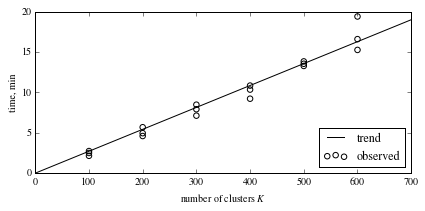

In [82]:
plt.figure(figsize=(6, 3))

ts_m = np.array(ts) / 60.0
plt.scatter(ks, ts_m, facecolors='none', s=30, edgecolors='black', label='observed')
plt.plot([0, 700], model.predict([0, 700]) / 60.0, color='black', label='trend')
plt.xlim([0, 700])
plt.ylim([0, 20])
plt.legend(loc='lower right')
plt.xlabel('number of clusters $K$')
plt.ylabel('time, min')

plt.tight_layout()
plt.savefig('figures/k-vs-time.pdf', format='pdf')

plt.show()

Let's try the same for minibatch

In [97]:
labels = {}

In [23]:
ks = [100, 200, 300, 400, 500, 600]
times_mb = []
labels_mb = {}

for k in ks:
    for i in xrange(10):
        t0 = time()
        km = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km.fit(X)
        labels_mb[(k, i)] = km.labels_
        taken_time = time() - t0
        print "k=%d, done in %0.5fs." % (k, taken_time)
        times_mb.append((k, taken_time))

k=100, done in 1.87100s.
k=100, done in 1.19300s.
k=100, done in 1.16300s.
k=100, done in 0.85900s.
k=100, done in 1.44700s.
k=100, done in 0.96800s.
k=100, done in 1.37600s.
k=100, done in 2.86000s.
k=100, done in 2.30800s.
k=100, done in 1.24800s.
k=200, done in 4.13600s.
k=200, done in 2.56200s.
k=200, done in 2.91000s.
k=200, done in 3.29000s.
k=200, done in 3.35500s.
k=200, done in 3.22000s.
k=200, done in 2.00800s.
k=200, done in 3.39800s.
k=200, done in 2.82700s.
k=200, done in 3.79000s.
k=300, done in 6.02200s.
k=300, done in 4.67200s.
k=300, done in 3.67600s.
k=300, done in 5.11800s.
k=300, done in 5.97900s.
k=300, done in 8.70800s.
k=300, done in 6.79600s.
k=300, done in 4.54900s.
k=300, done in 5.30400s.
k=300, done in 6.43000s.
k=400, done in 6.43900s.
k=400, done in 7.17500s.
k=400, done in 9.82000s.
k=400, done in 10.18100s.
k=400, done in 9.98000s.
k=400, done in 14.54300s.
k=400, done in 7.67500s.
k=400, done in 8.42700s.
k=400, done in 6.83500s.
k=400, done in 8.59000s

In [30]:
ks_mb = []
purities_mb = []
lens_mb = []

for (k, i) in sorted(labels_mb.keys()):
    assignment = labels_mb[(k, i)]
    ks_mb.append(k)
    pur = evaluate.overall_purity(assignment)
    purities_mb.append(pur)
    ln = len(evaluate.high_purity_clusters(assignment, threshold=0.8, min_size=3))
    lens_mb.append(ln)
    
    print k, pur, ln

100 0.139880952381 2
100 0.136149609097 0
100 0.127443141436 0
100 0.14565565032 0
100 0.134017412935 1
100 0.138726012793 1
100 0.145566808813 1
100 0.142857142857 0
100 0.151297085999 2
100 0.137970859986 1
200 0.151918976546 1
200 0.14618869936 0
200 0.14974235963 1
200 0.149120469083 0
200 0.151430348259 0
200 0.149964463397 1
200 0.147432480455 2
200 0.151252665245 1
200 0.14974235963 0
200 0.146410803127 2
300 0.139303482587 1
300 0.143123667377 2
300 0.133617626155 1
300 0.13921464108 0
300 0.138726012793 1
300 0.140369580668 0
300 0.135483297797 2
300 0.137793176972 0
300 0.128731343284 4
300 0.137437810945 2
400 0.148898365316 2
400 0.138148542999 1
400 0.139969793888 0
400 0.144323027719 3
400 0.137748756219 3
400 0.144811656006 3
400 0.149875621891 2
400 0.13868159204 1
400 0.140280739161 1
400 0.147521321962 0
500 0.137615493959 2
500 0.134195095949 1
500 0.156494314144 2
500 0.138459488273 1
500 0.137482231699 1
500 0.155739161336 3
500 0.151430348259 2
500 0.133972992182 

In [261]:
df_km = pd.DataFrame({'k': ks_km, 'purity': purities_km, 'sizes': lens_km})
df_mb = pd.DataFrame({'k': ks_mb, 'purity': purities_mb, 'sizes': lens_mb})

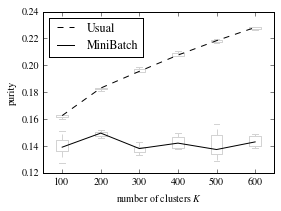

In [264]:
plt.figure(figsize=(4, 3))

idx = [i for (i, n) in df_km.groupby('k')]

bp = plt.boxplot([n.purity.values for (i, n) in df_km.groupby('k')], positions=idx, widths=30)
plt.setp(bp['boxes'], color='lightgray')
plt.setp(bp['medians'], color='none')
plt.setp(bp['whiskers'], color='lightgray')
plt.setp(bp['fliers'], marker='None')
plt.setp(bp['caps'], color='lightgray')

plt.plot(idx, df_km.groupby('k').median().purity, color='black', linestyle='--', label='Usual')

bp = plt.boxplot([n.purity.values for (i, n) in df_mb.groupby('k')], positions=idx, widths=30)
plt.setp(bp['boxes'], color='lightgray')
plt.setp(bp['medians'], color='none')
plt.setp(bp['whiskers'], color='lightgray')
plt.setp(bp['fliers'], marker='None')
plt.setp(bp['caps'], color='lightgray')

plt.plot(idx, df_mb.groupby('k').median().purity, color='black', label='MiniBatch')

plt.xlim(50, 650)
plt.xlabel('number of clusters $K$')
plt.ylabel('purity')
plt.legend(loc='upper left')

plt.tight_layout()

plt.savefig('figures/k-vs-purity2.pdf', format='pdf')

plt.show()

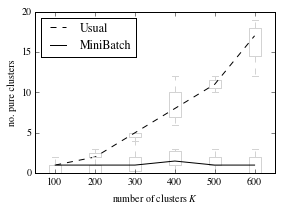

In [265]:
plt.figure(figsize=(4, 3))

idx = [i for (i, n) in df_km.groupby('k')]

bp = plt.boxplot([n.sizes.values for (i, n) in df_km.groupby('k')], positions=idx, widths=30)
plt.setp(bp['boxes'], color='lightgray')
plt.setp(bp['medians'], color='none')
plt.setp(bp['whiskers'], color='lightgray')
plt.setp(bp['fliers'], marker='None')
plt.setp(bp['caps'], color='lightgray')

plt.plot(idx, df_km.groupby('k').median().sizes, color='black', linestyle='--', label='Usual')

bp = plt.boxplot([n.sizes.values for (i, n) in df_mb.groupby('k')], positions=idx, widths=30)
plt.setp(bp['boxes'], color='lightgray')
plt.setp(bp['medians'], color='none')
plt.setp(bp['whiskers'], color='lightgray')
plt.setp(bp['fliers'], marker='None')
plt.setp(bp['caps'], color='lightgray')

plt.plot(idx, df_mb.groupby('k').median().sizes, color='black', label='MiniBatch')

plt.xlim(50, 650)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='upper left')

plt.tight_layout()

plt.savefig('figures/k-vs-len2.pdf', format='pdf')

plt.show()

In [101]:
ks, ts = zip(*times)
print 'ks =', list(ks)
print 'ts =', list(ts)

ks = [100, 100, 100, 200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500, 600, 600, 600]
ts = [1.3640000820159912, 1.063999891281128, 1.4620001316070557, 2.001999855041504, 2.5290000438690186, 2.0840001106262207, 3.4070000648498535, 3.747999906539917, 7.823999881744385, 6.116000175476074, 5.105000019073486, 5.781000137329102, 8.726999998092651, 7.390000104904175, 7.740999937057495, 9.68500018119812, 10.348999977111816, 9.505000114440918]


In [113]:
model = sm.OLS(ts, ks).fit()
model.rsquared

0.97230275439100544

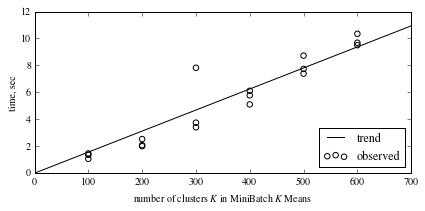

In [114]:
plt.figure(figsize=(6, 3))

plt.scatter(ks, ts, facecolors='none', s=30, edgecolors='black', label='observed')
plt.plot([0, 700], model.predict([0, 700]), color='black', label='trend')
plt.xlim([0, 700])
plt.ylim([0, 12])
plt.legend(loc='lower right')
plt.xlabel('number of clusters $K$ in MiniBatch $K$ Means')
plt.ylabel('time, sec')

plt.tight_layout()
plt.savefig('figures/k-vs-time-minibatch.pdf', format='pdf')

plt.show()

In [118]:
purities = []
no_pure = []

for (k, i), assignment in labels.items():
    cluster_purity = evaluate.overall_purity(assignment)
    purities.append(cluster_purity)
    no_pure_clusters = len(evaluate.high_purity_clusters(assignment, threshold=0.8, min_size=3))
    no_pure.append(no_pure_clusters)

    print 'purity for K=%d is %0.4f number of >0.8 clusters: %d' % (k, cluster_purity, no_pure_clusters)

purity for K=300 is 0.1437 number of >0.8 clusters: 3
purity for K=200 is 0.1499 number of >0.8 clusters: 1
purity for K=300 is 0.1306 number of >0.8 clusters: 0
purity for K=200 is 0.1507 number of >0.8 clusters: 3
purity for K=500 is 0.1357 number of >0.8 clusters: 0
purity for K=200 is 0.1437 number of >0.8 clusters: 1
purity for K=500 is 0.1361 number of >0.8 clusters: 2
purity for K=400 is 0.1375 number of >0.8 clusters: 0
purity for K=500 is 0.1445 number of >0.8 clusters: 1
purity for K=400 is 0.1425 number of >0.8 clusters: 1
purity for K=400 is 0.1399 number of >0.8 clusters: 1
purity for K=600 is 0.1402 number of >0.8 clusters: 0
purity for K=600 is 0.1503 number of >0.8 clusters: 0
purity for K=100 is 0.1390 number of >0.8 clusters: 0
purity for K=600 is 0.1554 number of >0.8 clusters: 1
purity for K=100 is 0.1394 number of >0.8 clusters: 1
purity for K=100 is 0.1421 number of >0.8 clusters: 1
purity for K=300 is 0.1352 number of >0.8 clusters: 1


In [271]:
ks = range(250, 15001, 250)

In [272]:
km_grid_hyperparam_res = {}
sizes_km = {}
purity_km = {}

In [273]:
for k in ks:
    for i in [0, 1, 2, 3, 4]:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X)
        km_grid_hyperparam_res[(k, i)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        purity_km[(k, i)] = cluster_purity

        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))
        sizes_km[(k, i)] = no_pure_clusters
        print 'purity for k=%d is %0.4f, number of >0.8 clusters: %d' % (k, cluster_purity, no_pure_clusters)

purity for k=250 is 0.1346, number of >0.8 clusters: 0
purity for k=250 is 0.1486, number of >0.8 clusters: 1
purity for k=250 is 0.1401, number of >0.8 clusters: 0
purity for k=250 is 0.1313, number of >0.8 clusters: 2
purity for k=250 is 0.1413, number of >0.8 clusters: 0
purity for k=500 is 0.1580, number of >0.8 clusters: 2
purity for k=500 is 0.1403, number of >0.8 clusters: 1
purity for k=500 is 0.1320, number of >0.8 clusters: 2
purity for k=500 is 0.1419, number of >0.8 clusters: 1
purity for k=500 is 0.1417, number of >0.8 clusters: 2
purity for k=750 is 0.1441, number of >0.8 clusters: 1
purity for k=750 is 0.1378, number of >0.8 clusters: 2
purity for k=750 is 0.1407, number of >0.8 clusters: 1
purity for k=750 is 0.1527, number of >0.8 clusters: 2
purity for k=750 is 0.1352, number of >0.8 clusters: 2
purity for k=1000 is 0.1578, number of >0.8 clusters: 2
purity for k=1000 is 0.1487, number of >0.8 clusters: 1
purity for k=1000 is 0.1361, number of >0.8 clusters: 0
purity 

KeyboardInterrupt: 

In [286]:
df_size = pd.DataFrame([(k, i, v) for (k, i), v in sizes_km.items()], columns=['k', 'i', 'sizes'])

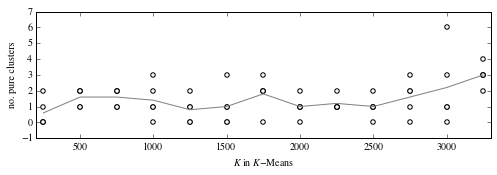

In [313]:
ax = df_size.plot(kind='scatter', x='k', y='sizes', grid=0, edgecolors='black', color='white', figsize=(7,2.5))

df_size.groupby('k').mean().sizes.plot(ax=ax, grid=0, color='grey')

plt.ylabel('no. pure clusters')
plt.xlabel('$K$ in $K$-Means')

plt.xlim(200, 3300)

plt.tight_layout()
plt.savefig('figures/k-vs-len-mb.pdf', format='pdf')

plt.show()

Use the best one:

In [322]:
best_ass = labels_km[(600, 1)]
evaluate.high_purity_clusters(best_ass, threshold=0.8, min_size=3)

evaluate.report_overall(best_ass, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.2286
number of high purity clusters of size at least 5 is 19

- Astronomical catalogues (id=66) size=53, purity=0.9811
- Stochastic processes (id=506) size=39, purity=0.8718
- Theory of computation (id=185) size=17, purity=1.0000
- Thermodynamics (id=377) size=16, purity=0.8750
- Statistics (id=374) size=13, purity=0.8462
- National Basketball Association seasons (id=13) size=12, purity=1.0000
- Numerical differential equations (id=528) size=12, purity=0.9167
- Statistics (id=566) size=10, purity=0.8000
- Differential geometry (id=346) size=9, purity=1.0000
- Constellations (id=364) size=7, purity=0.8571
- Astronomical catalogues of stars (id=494) size=7, purity=0.8571
- Constellations (id=393) size=6, purity=1.0000
- Differential equations (id=586) size=6, purity=1.0000
- Quantum mechanics (id=404) size=5, purity=1.0000
- Metallic elements (id=552) size=5, purity=0.8000
- Main sequence stars (id=444) size=4, purity=1.0000
- Number theory (id=132) size=3, purity=1.0000

In [328]:
evaluate.print_cluster(best_ass, 494)

cluster 494, size: 7
- Luminosity distance (categories: Concepts in physics, Measurement, Physical quantities, Astronomical sub-disciplines, Observational astronomy, ...) π D F m M L δ D_L D_M θ z D_C
- Rho Geminorum (categories: Constellations, Constellations listed by Ptolemy, Astronomical catalogues, Bayer objects, Astronomical catalogues of stars, ...) m M D_L
- HD 154088 (categories: Astronomical catalogues of stars, Henry Draper Catalogue objects) m M D_L
- HD 108063 (categories: Constellations, Constellations listed by Ptolemy, Astronomical catalogues of stars, Henry Draper Catalogue objects, Southern constellations, ...) m M D_L
- Kappa Fornacis (categories: Constellations, Astronomical catalogues, Bayer objects, Astronomical catalogues of stars, Henry Draper Catalogue objects, ...) m M D_L
- HD 41742/41700 (categories: Constellations, Astronomical catalogues of stars, Henry Draper Catalogue objects, Southern constellations, Hipparcos objects, ...) m M D_L
- Nu2 Lupi (categorie

Let's try different number of orthogonal vectors in LSA basis

## LSA

In [15]:
from sklearn.decomposition import NMF

In [67]:
t0 = time()

n = 250

nmf = NMF(n_components=n)
X_red_grid = nmf.fit_transform(X)
X_red_grid = normalizer.fit_transform(X_red_grid)

print "done in %0.3fs." % (time() - t0)

done in 5269.633s.


First, let's check performance $K$-Means vs MiniBatch $K$ Means

In [333]:
n = 150

U, S, Vt = randomized_svd(X, n_components=n)
X_red = X.dot(Vt.T)
X_red = normalizer.fit_transform(X_red_grid)

In [335]:
ks = [100, 200, 300, 400, 500, 600]

labels_mb = {}
no_pur_mb = []
pur_mb = []

labels_km = {}
no_pur_km = []
pur_km = []

for k in ks:
    for i in xrange(5):
        km = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km.fit(X_red)
        labels_mb[(k, i)] = km.labels_
        assignment = km.labels_
        cluster_purity = evaluate.overall_purity(assignment)
        pur_mb.append((k, cluster_purity))
        no_pure_clusters = len(evaluate.high_purity_clusters(assignment, threshold=0.8, min_size=3))
        no_pur_mb.append((k, no_pure_clusters))
        print 'MB: purity for K=%d is %0.4f number of >0.8 clusters: %d' % (k, cluster_purity, no_pure_clusters)

    for i in xrange(1):
        km = KMeans(n_clusters=k, init='random')
        km.fit(X_red)
        labels_km[(k, i)] = km.labels_
        assignment = km.labels_
        cluster_purity = evaluate.overall_purity(assignment)
        pur_km.append((k, cluster_purity))
        no_pure_clusters = len(evaluate.high_purity_clusters(assignment, threshold=0.8, min_size=3))
        no_pur_km.append((k, no_pure_clusters))
        print 'KM: purity for K=%d is %0.4f number of >0.8 clusters: %d' % (k, cluster_purity, no_pure_clusters)

MB: purity for K=100 is 0.1625 number of >0.8 clusters: 0
MB: purity for K=100 is 0.1612 number of >0.8 clusters: 2
MB: purity for K=100 is 0.1600 number of >0.8 clusters: 1
MB: purity for K=100 is 0.1582 number of >0.8 clusters: 0
MB: purity for K=100 is 0.1620 number of >0.8 clusters: 0
KM: purity for K=100 is 0.1617 number of >0.8 clusters: 0
MB: purity for K=200 is 0.1799 number of >0.8 clusters: 1
MB: purity for K=200 is 0.1765 number of >0.8 clusters: 1
MB: purity for K=200 is 0.1768 number of >0.8 clusters: 1
MB: purity for K=200 is 0.1745 number of >0.8 clusters: 0
MB: purity for K=200 is 0.1755 number of >0.8 clusters: 1
KM: purity for K=200 is 0.1817 number of >0.8 clusters: 1
MB: purity for K=300 is 0.1919 number of >0.8 clusters: 4
MB: purity for K=300 is 0.1937 number of >0.8 clusters: 4
MB: purity for K=300 is 0.1837 number of >0.8 clusters: 5
MB: purity for K=300 is 0.1896 number of >0.8 clusters: 3
MB: purity for K=300 is 0.1918 number of >0.8 clusters: 5
KM: purity for

In [373]:
a, b = zip(*pur_mb)
c, d = zip(*no_pur_mb)

df_pur_mb = pd.DataFrame(zip(a, b, c, d), columns=['k', 'purity', 'k0', 'sizes'])
del df_pur_mb['k0']

a, b = zip(*pur_km)
c, d = zip(*no_pur_km)

df_pur_km = pd.DataFrame(zip(a, b, c, d), columns=['k', 'purity', 'k0', 'sizes'])
del df_pur_km['k0']

df_pur_mb['ref'] = 'mb'
df_pur_km['ref'] = 'km'

df = df_pur_km.append(df_pur_mb)

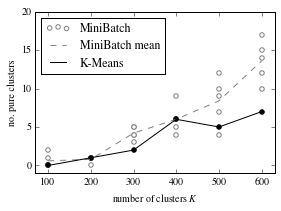

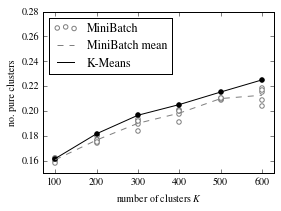

In [434]:
ax = df_pur_mb.plot(kind='scatter', x='k', y='sizes', label='MiniBatch', 
                    edgecolors='grey', color='white', figsize=(4, 3))
df_pur_mb.groupby('k').mean().sizes.plot(ax=ax, label='MiniBatch mean', color='grey', linestyle='--')

df_pur_km.plot(kind='scatter', x='k', y='sizes', ax=ax, color='black')
df_pur_km.groupby('k').median().sizes.plot(ax=ax, color='black', label='K-Means')

plt.grid(0)
plt.xlim(70, 630)
plt.ylim(-1, 20)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[2], handles[0], handles[1]], loc='upper left')

plt.tight_layout()
plt.savefig('figures/k-vs-mb-svd-len.pdf', format='pdf')

plt.show()



ax = df_pur_mb.plot(kind='scatter', x='k', y='purity', label='MiniBatch', 
                    edgecolors='grey', color='white', figsize=(4, 3))
df_pur_mb.groupby('k').mean().purity.plot(ax=ax, label='MiniBatch mean', color='grey', linestyle='--')

df_pur_km.plot(kind='scatter', x='k', y='purity', ax=ax, color='black')
df_pur_km.groupby('k').median().purity.plot(ax=ax, color='black', label='K-Means')

plt.grid(0)
plt.xlim(70, 630)
plt.ylim(0.15, 0.28)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[2], handles[0], handles[1]], loc='upper left')

plt.tight_layout()
plt.savefig('figures/k-vs-mb-svd-purity.pdf', format='pdf')

plt.show()

In [ ]:
km_grid_hyperparam_purity = []
km_grid_hyperparam_len = []
km_grid_hyperparam_res = {}

In [18]:
for n in [250, 350, 500]:
    print 'doing LSA with %d components...' % n
    print

    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red_grid = X.dot(V)
    X_red_grid = normalizer.fit_transform(X_red_grid)

    ks = [k for k in xrange(500, 15001, 500)]
    
    for k in ks:
        for i in xrange(3):
            km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
            km_grid.fit(X_red_grid)

            km_grid_hyperparam_res[(n, k, i)] = km_grid.labels_
            cluster_purity = evaluate.overall_purity(km_grid.labels_)
            km_grid_hyperparam_purity.append((n, k, i, cluster_purity))

            no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))
            km_grid_hyperparam_len.append((n, k, i, no_pure_clusters))
            print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

doing LSA with 250 components...

purity for n=250, k=7500 is 0.4959, number of >0.8 clusters: 185
purity for n=250, k=7500 is 0.4962, number of >0.8 clusters: 162
purity for n=250, k=7500 is 0.4996, number of >0.8 clusters: 163
purity for n=250, k=8000 is 0.5344, number of >0.8 clusters: 199
purity for n=250, k=8000 is 0.5344, number of >0.8 clusters: 195
purity for n=250, k=8000 is 0.5365, number of >0.8 clusters: 202
purity for n=250, k=8500 is 0.5521, number of >0.8 clusters: 206
purity for n=250, k=8500 is 0.5513, number of >0.8 clusters: 196
purity for n=250, k=8500 is 0.5492, number of >0.8 clusters: 193
purity for n=250, k=9000 is 0.5673, number of >0.8 clusters: 210
purity for n=250, k=9000 is 0.5674, number of >0.8 clusters: 188
purity for n=250, k=9000 is 0.5682, number of >0.8 clusters: 188
purity for n=250, k=9500 is 0.5836, number of >0.8 clusters: 191
purity for n=250, k=9500 is 0.5843, number of >0.8 clusters: 213
purity for n=250, k=9500 is 0.5827, number of >0.8 clust

In [20]:
import pickle

In [21]:
pickle.dump(km_grid_hyperparam_res, file('C:/tmp/mlp/namespaces/k-means-def-cleaned-07-20-lsa-graph.bin', 'w'))

In [22]:
df1 = pd.DataFrame(km_grid_hyperparam_purity, columns=['n', 'k', 'i', 'purity'])
df2 = pd.DataFrame(km_grid_hyperparam_len, columns=['n', 'k', 'i', 'sizes'])
df_res = pd.concat([df1, df2], axis=1, join='inner')[[0, 1, 3, 7]]

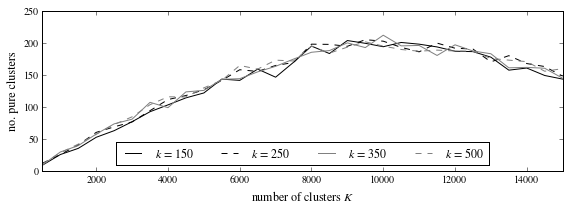

In [34]:
visual = {150: ('black', '-'), 250: ('black', '--'), 350: ('grey', '-'), 500: ('grey', '--')}

for n, g in df_res.groupby('n'):
    color, line = visual[n]
    g.groupby('k').mean().sizes.plot(figsize=(8, 3), label='$k$ = %d' % n, color=color, linestyle=line)

plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='lower center', ncol=4)

plt.tight_layout()
plt.savefig('figures/k-vs-kmeans-len-nodef.pdf', format='pdf')
plt.show()

In [41]:
clustering = km_grid_hyperparam_res[(250, 9500, 2)]
evaluate.report_overall(clustering, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.5827
number of high purity clusters of size at least 5 is 213

- Astronomical catalogues (id=248) size=53, purity=0.9811
- Quantum mechanics (id=749) size=14, purity=0.9286
- Electrochemistry (id=181) size=12, purity=0.8333
- National Basketball Association seasons (id=5459) size=12, purity=1.0000
- Particle physics (id=3022) size=10, purity=0.8000
- Partial differential equations (id=5370) size=10, purity=0.8000
- Electromagnetism (id=7610) size=10, purity=1.0000
- Topology (id=9452) size=10, purity=0.9000
- Measure theory (id=5456) size=8, purity=0.8750
- Propositional calculus (id=6288) size=8, purity=0.8750
- Baseball statistics (id=3583) size=7, purity=0.8571
- Group theory (id=5092) size=7, purity=0.8571
- Abstract algebra (id=598) size=6, purity=0.8333
- Astronomical catalogues of stars (id=974) size=6, purity=1.0000
- Constellations (id=1882) size=6, purity=1.0000
- Linear algebra (id=2931) size=6, purity=0.8333
- Cartographic projections (id=3379) size=6, puri

In [42]:
evaluate.print_cluster(clustering, 5456)

cluster 5456, size: 8
- Signed measure (categories: Measure theory, Calculus, Integral calculus, Measures (measure theory)) Σ E d f l n P R t x N ν μ
- Ergodicity (categories: Mathematical analysis, Statistics, Applied mathematics, Dynamical systems, Probability theory, ...) Σ E g H n T X μ t
- Support (measure theory) (categories: Mathematical analysis, Measure theory) Σ N_x D g f C T L R U t X x λ μ d
- Convergence of measures (categories: Mathematical analysis, Measure theory) P_n x d g F Ω f μ_n l n P S R ϵ t X ϕ ν μ δ
- Riesz–Markov–Kakutani representation theorem (categories: Geometry, Manifolds, Functional analysis, Measure theory, Category theory, ...) E d f ψ K α U X x μ
- Invariant measure (categories: Mathematical analysis, Fields of mathematics, Mechanics, Dynamical systems, Mathematical physics, ...) Σ B φ f μ S R t x b Id T_a T
- Fernique's theorem (categories: Mathematical theorems, Probability theory, Measure theory, Theorems in analysis, Probability theorems, ...) E l_

In [43]:
evaluate.find_identifier(clustering, purity_threshold=0.8, id=u'μ', min_size=3, collection_weighting=0)

overall purity 0.5827
number of high purity clusters of size at least 5 is 213

category "Particle physics", cluster_id=353, size=5:
top categories: [(u'Particle physics', 5), (u'Quantum mechanics', 4), (u'Theoretical physics', 4), (u'Mechanics', 3), (u'Modern physics', 3)]
     μ: (gamma matrices: 0.95), (lebesgue: 0.89), (measure: 0.83)
category "Special functions", cluster_id=483, size=3:
top categories: [(u'Special functions', 3), (u'Combinatorics', 2), (u'Lie groups', 2), (u'Gamma and related functions', 1), (u'Complex analysis', 1)]
     μ: (partitions: 0.99), (expressions: 0.86)
category "Quantum mechanics", cluster_id=749, size=14:
top categories: [(u'Quantum mechanics', 13), (u'Theoretical physics', 9), (u'Particle physics', 9), (u'Quantum field theory', 7), (u'Atomic physics', 3)]
     μ: (molecular dipole operator: 0.96), (ψand: 0.89)
category "Fluid dynamics", cluster_id=777, size=5:
top categories: [(u'Fluid dynamics', 5), (u'Physics', 3), (u'Turbulence', 2), (u'Fluid mech

In [44]:
nmf_km_grid_hyperparam_lp = []
nmf_km_grid_hyperparam_res = {}

for n in [150, 250, 350]:
    print 'doing LSA with %d components...' % n
    print


    nmf = NMF(n_components=n)
    X_red_grid = nmf.fit_transform(X)
    X_red_grid = normalizer.fit_transform(X_red_grid)

    ks = [k for k in xrange(500, 15001, 500)]

    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_red_grid)

        nmf_km_grid_hyperparam_res[(n, k)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))

        nmf_km_grid_hyperparam_lp.append((n, k, cluster_purity, no_pure_clusters))
        print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

doing LSA with 150 components...

purity for n=150, k=500 is 0.2082, number of >0.8 clusters: 6
purity for n=150, k=1000 is 0.2415, number of >0.8 clusters: 18
purity for n=150, k=1500 is 0.2694, number of >0.8 clusters: 37
purity for n=150, k=2000 is 0.2868, number of >0.8 clusters: 43
purity for n=150, k=2500 is 0.3105, number of >0.8 clusters: 51
purity for n=150, k=3000 is 0.3388, number of >0.8 clusters: 86
purity for n=150, k=3500 is 0.3584, number of >0.8 clusters: 82
purity for n=150, k=4000 is 0.3766, number of >0.8 clusters: 93
purity for n=150, k=4500 is 0.3911, number of >0.8 clusters: 100
purity for n=150, k=5000 is 0.4156, number of >0.8 clusters: 117
purity for n=150, k=5500 is 0.4261, number of >0.8 clusters: 134
purity for n=150, k=6000 is 0.4533, number of >0.8 clusters: 151
purity for n=150, k=6500 is 0.4736, number of >0.8 clusters: 160
purity for n=150, k=7000 is 0.4721, number of >0.8 clusters: 126
purity for n=150, k=7500 is 0.5059, number of >0.8 clusters: 175
p

In [45]:
pickle.dump(nmf_km_grid_hyperparam_res, file('C:/tmp/mlp/namespaces/k-means-def-cleaned-07-20-nmf-graph.bin', 'w'))

In [48]:
df_nf = pd.DataFrame(nmf_km_grid_hyperparam_lp, columns=['n', 'k', 'purity', 'sizes'])
df_nf.head()

,n,k,purity,sizes
0,150,500,0.208244,6
1,150,1000,0.241516,18
2,150,1500,0.269367,37
3,150,2000,0.286825,43
4,150,2500,0.310545,51


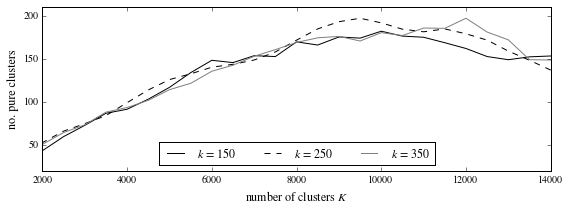

In [74]:
visual = {150: ('black', '-'), 250: ('black', '--'), 350: ('grey', '-')}

for n, g in df_nf.groupby('n'):
    color, line = visual[n]
    med = g.groupby('k').sizes.median()
    smoothed = pd.stats.moments.rolling_mean(med, window=3, center=True)
    smoothed.plot(figsize=(8, 3), label='$k$ = %d' % n, color=color, linestyle=line)


plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='lower center', ncol=3)
plt.xlim(2000, 14000)
plt.ylim(20, 210)

plt.tight_layout()
plt.savefig('figures/k-vs-kmeans-len-nmf-nodef.pdf', format='pdf')
plt.show()

In [75]:
clustering = nmf_km_grid_hyperparam_res[(250, 9500)]
evaluate.report_overall(clustering, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.5814
number of high purity clusters of size at least 5 is 200

- Astronomical catalogues (id=739) size=53, purity=0.9811
- Complex analysis (id=5994) size=18, purity=0.8333
- National Basketball Association seasons (id=1831) size=12, purity=1.0000
- Quantum mechanics (id=2435) size=12, purity=0.8333
- Mathematical analysis (id=2618) size=10, purity=0.8000
- Physics (id=8835) size=9, purity=0.8889
- Thermodynamics (id=1264) size=6, purity=0.8333
- Astronomical catalogues of stars (id=3644) size=6, purity=1.0000
- Knot theory (id=3991) size=6, purity=1.0000
- Stochastic processes (id=4552) size=6, purity=1.0000
- Physics (id=4572) size=6, purity=0.8333
- Stochastic processes (id=5440) size=6, purity=1.0000
- Statistics (id=5778) size=6, purity=0.8333
- Integral calculus (id=6185) size=6, purity=0.8333
- Multivariable calculus (id=6434) size=6, purity=0.8333
- Baseball statistics (id=6435) size=6, purity=0.8333
- Quantum mechanics (id=6709) size=6, purity=1.0000
- Analog 

In [76]:
evaluate.print_cluster(clustering, 5778)

cluster 5778, size: 6
- Pivotal quantity (categories: Statistics, Statistical theory, Scientific theories) s_Y s_X X_n X_i ζ θ ν μ ρ σ N Y_i Y X g n s r X_2 X_1 x z
- Errors and residuals in statistics (categories: Statistics, Statistical data types, Measurement, Mathematical optimization, Statistical theory, ...) σ χ X_n ε_i X_i n X_1 X N μ S_n
- Prediction interval (categories: Statistics, Statistical data types, Mathematical optimization, Data analysis, Econometrics, ...) Pr x_d x_i ϵ_d X_n ϵ_i X_i α γ β y_i y_d μ s_n σ E χ T_a N P T X Z S_n g Φ l n p s u t X_1 y z
- Cochran's theorem (categories: Mathematical theorems, Statistical theory, Probability distributions, Statistical theorems, Characterization of probability distributions) Q_k Q_i X_i r_i N_n r_k μ σ B χ U_k U_j U_i R U T Y X r_1 k j n Q_2 Q_1
- Skewness (categories: Statistics, Probability theory, Probability distributions, Theory of probability distributions, Statistical deviation and dispersion) Pr G_1 x_i γ_1 κ_3 k_3 

In [77]:
evaluate.find_identifier(clustering, purity_threshold=0.8, id=u'μ', min_size=3, collection_weighting=0)

overall purity 0.5814
number of high purity clusters of size at least 5 is 200

category "Probability distributions", cluster_id=3, size=3:
top categories: [(u'Probability distributions', 3), (u'Continuous distributions', 2), (u'Statistical data types', 2), (u'Directional statistics', 2), (u'Exponential family distributions', 2)]
     μ: (mean direction: 0.95), (second cumulant: 0.85), (argument: 0.83), (moment: 0.82)
category "Number theory", cluster_id=113, size=3:
top categories: [(u'Number theory', 3), (u'Numbers', 3), (u'Recreational mathematics', 2), (u'Analytic number theory', 2), (u'Combinatorics', 2)]
     μ: (measure*: 3.63), (equivalent: 0.88), (preserves: 0.83)
category "Numerical analysis", cluster_id=161, size=5:
top categories: [(u'Numerical analysis', 4), (u'Algorithms', 4), (u'Root-finding algorithms', 3), (u'Zero', 3), (u'Optimization algorithms and methods', 2)]
     μ: (step size: 0.93), (gradient descent: 0.84), (scale: 0.81)
category "Probability theory", cluster_

Effect of TF vs TF-IDF vs logTF-IDF

In [78]:
vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=False, sublinear_tf=False, min_df=2)
X_tf = vectorizer.fit_transform(ids)

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=False, sublinear_tf=True, min_df=2)
X_ltf = vectorizer.fit_transform(ids)

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=True, sublinear_tf=False, min_df=2)
X_tfidf = vectorizer.fit_transform(ids)

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=True, sublinear_tf=True, min_df=2)
X_ltfidf = vectorizer.fit_transform(ids)

In [79]:
Xs = {'TF': X_tf, 'logTF': X_ltf, 'TF-IDF': X_tfidf, 'logTF-IDF': X_ltfidf}

In [83]:
types_res = []

In [93]:
n = 350

In [94]:
for t, X_star in Xs.items():
    print 'trying %s...' % t

    U, S, Vt = randomized_svd(X_star, n_components=n)
    V = Vt.T

    X_red = X.dot(V)
    X_red = normalizer.fit_transform(X_red)

    ks = [k for k in xrange(6500, 11001, 500)]
    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_red)
        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))

        types_res.append((t, k, no_pure_clusters))
        print 'k=%d, number of >0.8 clusters: %d' % (k, no_pure_clusters)

    print    

trying TF...
k=6500, number of >0.8 clusters: 139
k=7000, number of >0.8 clusters: 171
k=7500, number of >0.8 clusters: 161
k=8000, number of >0.8 clusters: 190
k=8500, number of >0.8 clusters: 212
k=9000, number of >0.8 clusters: 185
k=9500, number of >0.8 clusters: 181
k=10000, number of >0.8 clusters: 203
k=10500, number of >0.8 clusters: 192
k=11000, number of >0.8 clusters: 205

trying logTF...
k=6500, number of >0.8 clusters: 149
k=7000, number of >0.8 clusters: 168
k=7500, number of >0.8 clusters: 176
k=8000, number of >0.8 clusters: 194
k=8500, number of >0.8 clusters: 187
k=9000, number of >0.8 clusters: 199
k=9500, number of >0.8 clusters: 203
k=10000, number of >0.8 clusters: 198
k=10500, number of >0.8 clusters: 214
k=11000, number of >0.8 clusters: 186

trying TF-IDF...
k=6500, number of >0.8 clusters: 144
k=7000, number of >0.8 clusters: 170
k=7500, number of >0.8 clusters: 172
k=8000, number of >0.8 clusters: 186
k=8500, number of >0.8 clusters: 210
k=9000, number of >0.

In [95]:
df_weight = pd.DataFrame(types_res, columns=('scheme', 'K', 'no'))

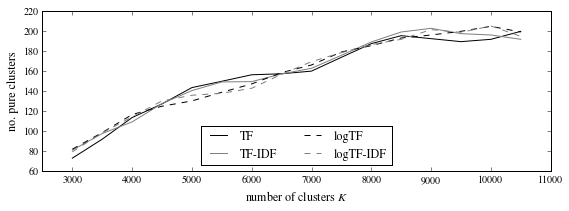

In [99]:
visual = {'TF': ('black', '-'), 'logTF': ('black', '--'), 'TF-IDF': ('grey', '-'), 'logTF-IDF': ('grey', '--')}

for n, g in df_weight.groupby('scheme'):
    color, line = visual[n]
    med = g.groupby('K').no.median()
    smoothed = pd.stats.moments.rolling_mean(med, window=3, center=True)
    smoothed.plot(figsize=(8, 3), label=n, color=color, linestyle=line)


plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='lower center', ncol=2)
# plt.xlim(2000, 14000)
# plt.ylim(20, 210)

plt.tight_layout()
plt.savefig('figures/nodef-weighing.pdf', format='pdf')
plt.show()

In [ ]:
from sklearn import random_projection

## Agglomerative


In [13]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
ns = [100, 250, 500, 750, 1000, 1250]
times = []

In [16]:
X_dense = X.toarray()

In [17]:
X_dense.shape

(22512L, 6075L)

In [22]:
X_dense.nbytes / (1024.0 * 1024 * 1024)

1.0189443826675415

In [107]:
for n in xrange(12000, 15001, 1000):
    X_n = X_dense[:n]

    for i in [0]:
        t0 = time()
        ward = AgglomerativeClustering(linkage='ward').fit(X_n)
        taken_time = time() - t0
        print "n=%d, done in %0.5fs." % (n, taken_time)
        times.append((n, taken_time))

n=12000, done in 1248.52700s.
n=13000, done in 1517.52700s.
n=14000, done in 1789.68700s.
n=15000, done in 2069.81400s.


In [198]:
ds = pd.DataFrame(times, columns=['n', 'time'])
# ds['n2'] = ds.n ** 2
fit = sm.ols('time ~ n +I(n ** 2) - 1', data=ds).fit()

In [223]:
N_doc

22512

In [226]:
X_dense.nbytes / (1024.0 * 1024 * 1024)

1.0189443826675415

In [199]:
fit.rsquared

0.99156521457595359

In [200]:
ns, ts = zip(*times)

In [201]:
fit.predict({'n': np.array(N_doc) }) / 60

array([ 76.96798085])

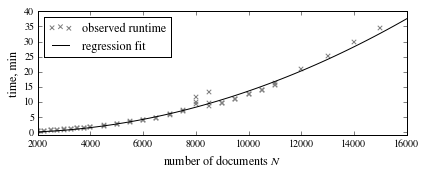

In [241]:
plt.figure(figsize=(6, 2.5))

rng = np.arange(0, 16001, 250)
test_ds = {'n': rng }

handle1 = plt.scatter(ns, np.array(ts) / 60.0, marker='x', color='grey', label='observed runtime')
handle2, = plt.plot(rng, fit.predict(test_ds) / 60.0, color='black', label='regression fit')

plt.xlabel('number of documents $N$')
plt.ylabel('time, min')
plt.xlim(2000, 16000)
plt.ylim(-1, 40)

plt.legend(handles=(handle1, handle2), loc='upper left')

plt.tight_layout()
plt.savefig('figures/agglo-time.pdf', format='pdf')

plt.show()


## Random projections

In [23]:
from sklearn import random_projection

In [24]:
rp_res = []

In [25]:
for i in xrange(10):
    print 'trying %s...' % i
    
    rp = random_projection.GaussianRandomProjection(n_components=250)
    X_new = rp.fit_transform(X)
    X_new = normalizer.fit_transform(X_new)
    
    ks = [k for k in xrange(6000, 13001, 250)]
    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_new)
        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))

        rp_res.append((i, k, no_pure_clusters))
        print 'k=%d, number of >0.8 clusters: %d' % (k, no_pure_clusters)

    print

trying 0...
k=6000, number of >0.8 clusters: 185
k=6250, number of >0.8 clusters: 181
k=6500, number of >0.8 clusters: 180
k=6750, number of >0.8 clusters: 191
k=7000, number of >0.8 clusters: 198
k=7250, number of >0.8 clusters: 178
k=7500, number of >0.8 clusters: 181
k=7750, number of >0.8 clusters: 214
k=8000, number of >0.8 clusters: 223
k=8250, number of >0.8 clusters: 224
k=8500, number of >0.8 clusters: 222
k=8750, number of >0.8 clusters: 216
k=9000, number of >0.8 clusters: 228
k=9250, number of >0.8 clusters: 214
k=9500, number of >0.8 clusters: 208
k=9750, number of >0.8 clusters: 215
k=10000, number of >0.8 clusters: 221
k=10250, number of >0.8 clusters: 235
k=10500, number of >0.8 clusters: 224
k=10750, number of >0.8 clusters: 207
k=11000, number of >0.8 clusters: 211
k=11250, number of >0.8 clusters: 221
k=11500, number of >0.8 clusters: 233
k=11750, number of >0.8 clusters: 212
k=12000, number of >0.8 clusters: 205
k=12250, number of >0.8 clusters: 203
k=12500, number 

KeyboardInterrupt: 

In [27]:
import pickle

In [28]:
pickle.dump(rp_res, file('C:/tmp/mlp/namespaces/rp_res.bin', 'w'))

## DB-SCAN


In [296]:
def print_cnt(cnt):
    for id, c in cnt.most_common():
        print u'(%s, %d)' % (id, c),

In [241]:
k = 50

In [265]:
def chunks(X, step):
    l = X.shape[0]
    for i in xrange(0, l, step):
        if i + step < l:
            yield i, i+step, X[i:i+step]
        else:
            yield i, l, X[i:l]

In [274]:
t0 = time()

top_indexes = []
cos_sim_matrix = scipy.sparse.dok_matrix((N_doc, N_doc))

for beg, end, X_chunk in chunks(X, 500):
    print 'step (%d, %d) of len %d...' % (beg, end, end - beg)
    X_500 = X_chunk * X.T
    
    for j in xrange(end - beg):
        row = X_500.getrow(j)
        sim_indx = row.data.argsort()[::-1][:(k+1)]
        cos_sim_matrix[beg + j, row.indices[sim_indx]] = row.data[sim_indx]
        top_indexes.append(row.indices[sim_indx][1:])

cos_sim_matrix = scipy.sparse.csr_matrix(cos_sim_matrix)
print "done in %0.3fs." % (time() - t0)

step (0, 500) of len 500...
step (500, 1000) of len 500...
step (1000, 1500) of len 500...
step (1500, 2000) of len 500...
step (2000, 2500) of len 500...
step (2500, 3000) of len 500...
step (3000, 3500) of len 500...
step (3500, 4000) of len 500...
step (4000, 4500) of len 500...
step (4500, 5000) of len 500...
step (5000, 5500) of len 500...
step (5500, 6000) of len 500...
step (6000, 6500) of len 500...
step (6500, 7000) of len 500...
step (7000, 7500) of len 500...
step (7500, 8000) of len 500...
step (8000, 8500) of len 500...
step (8500, 9000) of len 500...
step (9000, 9500) of len 500...
step (9500, 10000) of len 500...
step (10000, 10500) of len 500...
step (10500, 11000) of len 500...
step (11000, 11500) of len 500...
step (11500, 12000) of len 500...
step (12000, 12500) of len 500...
step (12500, 13000) of len 500...
step (13000, 13500) of len 500...
step (13500, 14000) of len 500...
step (14000, 14500) of len 500...
step (14500, 15000) of len 500...
step (15000, 15500) of l

In [310]:
doc1 = title_idx['Singular value decomposition']
doc2 = top_indexes[doc1][0]

print titles[doc1]
print_cnt(ids[doc1])
print 

print titles[doc2]
print_cnt(ids[doc2])
print 

print 'common'
print_cnt(ids[doc1] & ids[doc2])
print 

print 'cosine', X[doc1] * X[doc2].T


Singular value decomposition
(m, 211) (p, 206) (M, 65) (V, 45) (U, 28) (Σ, 27) (x, 17) (T, 12) (u, 11) (v, 11) (S, 10) (D, 10) (z, 10) (σ, 8) (z_0, 7) (U_1, 7) (σ_i, 7) (σ_1, 5) (T_f, 5) (z_1, 5) (z_2, 5) (z_3, 5) (n, 5) (U_2, 4) (ψ, 4) (R, 4) (r, 4) (MV_1, 4) (j, 3) (Ω, 3) (λ_1, 3) (λ_2, 3) (UDU, 3) (UV, 3) (MM, 3) (B, 2) (U_i, 2) (N, 2) (MV_2, 2) (V_1, 2) (V_2, 2) (C, 1) (Σ_n, 1) (σ_±, 1) (Σ_r, 1) (Σ_t, 1) (α, 1) (σ_3, 1) (σ_2, 1) (UIV, 1) (z_i, 1) (λ, 1) (V_i, 1) (t, 1) (f, 1) (U_n, 1) (U_r, 1) (VV, 1) (U_t, 1) (UU, 1) (σ_k, 1) (MV, 1)
Rule of Sarrus
(p, 14) (m, 14) (M, 3)
common
(p, 14) (m, 14) (M, 3)
cosine   (0, 0)	0.924763759721


In [309]:
import snn_dbscan

In [329]:
snn_res_params = []
snn_res = {}

In [331]:
ks = [10, 15, 20, 25, 30]

for k_snn in ks:
    snn_graph = []

    for i, idx in enumerate(top_indexes):
        snn_graph.append(set(idx[:k_snn]))

    epsilons = [3, 4, 5, 6, 7, 8, 9, 10]
    poins = [3, 4, 5, 6, 7, 8, 9, 10]
    
    for eps in epsilons:
        for min_pts in poins:
            res = np.array(snn_dbscan.dbscan(snn_graph, eps, min_pts))
            res[res == 'noise'] = 0
            res = res.astype(int)

            pur = evaluate.overall_purity(res)
            no = len(evaluate.high_purity_clusters(res, threshold=0.8, min_size=3))
        
            snn_res_params.append((k_snn, eps, min_pts, pur, no))
            snn_res[(k_snn, eps, min_pts)] = res
    
            print 'k=%d, eps=%d, min_pts=%d => purity=%0.4f, len=%d' % (k_snn, eps, min_pts, pur, no)

k=10, eps=3, min_pts=3 => purity=0.4468, len=105
k=10, eps=3, min_pts=4 => purity=0.4375, len=103
k=10, eps=3, min_pts=5 => purity=0.4273, len=105
k=10, eps=3, min_pts=6 => purity=0.4187, len=95
k=10, eps=3, min_pts=7 => purity=0.4092, len=94
k=10, eps=3, min_pts=8 => purity=0.3989, len=92
k=10, eps=3, min_pts=9 => purity=0.3890, len=94
k=10, eps=3, min_pts=10 => purity=0.3785, len=84
k=10, eps=4, min_pts=3 => purity=0.4310, len=124
k=10, eps=4, min_pts=4 => purity=0.4113, len=111
k=10, eps=4, min_pts=5 => purity=0.3939, len=100
k=10, eps=4, min_pts=6 => purity=0.3798, len=86
k=10, eps=4, min_pts=7 => purity=0.3657, len=85
k=10, eps=4, min_pts=8 => purity=0.3528, len=82
k=10, eps=4, min_pts=9 => purity=0.3385, len=79
k=10, eps=4, min_pts=10 => purity=0.3243, len=69
k=10, eps=5, min_pts=3 => purity=0.3786, len=102
k=10, eps=5, min_pts=4 => purity=0.3521, len=82
k=10, eps=5, min_pts=5 => purity=0.3334, len=75
k=10, eps=5, min_pts=6 => purity=0.3149, len=62
k=10, eps=5, min_pts=7 => purit

KeyboardInterrupt: 

In [337]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [458]:
snn_df = pd.DataFrame(snn_res_params, columns=('k_snn', 'eps', 'min_pts', 'pur', 'no'))

In [484]:
snn10 = snn_df[snn_df.k_snn == 10][['eps', 'min_pts', 'no']]
snn10 = snn10.groupby(by=['eps', 'min_pts']).mean()
snn10.unstack()

no                              
min_pts   3    4    5   6   7   8   9   10
eps                                       
3        105  103  105  95  94  92  94  84
4        124  111  100  86  85  82  79  69
5        102   82   75  62  53  51  44  40
6         90   67   57  51  45  37  34  32
7         77   56   41  33  25  23  15  11
8         55   33   25  13   7   5   3   2
9         21   10    8   4   2   2   2   2
10        12    6    5   4   3   2   2   2

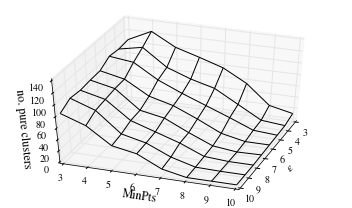

In [485]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')

Xs, Ys = np.meshgrid(epsilons, poins)
# plot surface, more colormaps: http://matplotlib.sourceforge.net/examples/pylab_examples/show_colormaps.html
# ax.plot_surface(Xs, Ys, Zs, rstride=4, cstride=4, alpha=0.4,cmap=cm.jet)

ax.plot_wireframe(Xs, Ys, snn10.unstack(), color='black')
ax.view_init(elev=40, azim=20)
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('MinPts')
ax.set_zlabel('no. pure clusters')

plt.tight_layout()
plt.savefig('figures/nodef-dbscan-cos10.pdf', format='pdf')
plt.show()

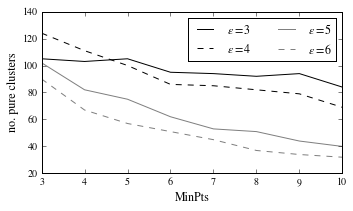

In [486]:
visual = {3: ('black', '-'), 4: ('black', '--'), 5: ('grey', '-'), 6: ('grey', '--')}

for i, n in snn10.reset_index().groupby('eps'):
    if i in visual:
        color, line = visual[i]
        n.set_index('min_pts').no.plot(figsize=(5, 3), color=color, linestyle=line, label=r'$\varepsilon=%d$' % i)

plt.grid(0)
plt.legend(ncol=2)

plt.xlabel('MinPts')
plt.ylabel('no. pure clusters')
plt.tight_layout()
plt.savefig('figures/nodef-dbscan-cos10-2.pdf', format='pdf')
plt.show()

In [475]:
snn10 = snn_df[snn_df.k_snn == 15][['eps', 'min_pts', 'no']]
snn10 = snn10.groupby(by=['eps', 'min_pts']).mean()
snn10.unstack()

no                            
min_pts  3   4   5   6   7   8   9   10
eps                                    
3        60  60  58  59  57  55  51  51
4        74  72  74  68  70  70  70  67
5        88  82  81  76  73  70  60  58
6        85  76  71  65  60  62  62  64
7        90  79  67  61  55  54  50  51
8        78  68  61  55  50  43  44  39
9        81  60  56  50  46  42  37  33
10       64  44  44  41  32  32  29  25

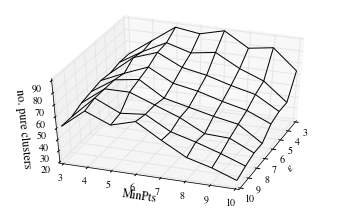

In [480]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')

Xs, Ys = np.meshgrid(epsilons, poins)
# plot surface, more colormaps: http://matplotlib.sourceforge.net/examples/pylab_examples/show_colormaps.html
# ax.plot_surface(Xs, Ys, Zs, rstride=4, cstride=4, alpha=0.4,cmap=cm.jet)

ax.plot_wireframe(Xs, Ys, snn10.unstack(), color='black')
ax.view_init(elev=40.0, azim=20)
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('MinPts')
ax.set_zlabel('no. pure clusters')

plt.tight_layout()
plt.savefig('figures/nodef-dbscan-cos15.pdf', format='pdf')
plt.show()

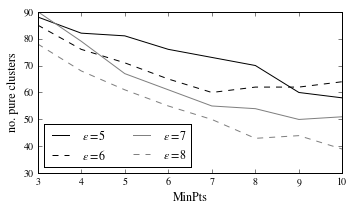

In [482]:
visual = {5: ('black', '-'), 6: ('black', '--'), 7: ('grey', '-'), 8: ('grey', '--')}

for i, n in snn10.reset_index().groupby('eps'):
    if i in visual:
        color, line = visual[i]
        n.set_index('min_pts').no.plot(figsize=(5, 3), color=color, linestyle=line, label=r'$\varepsilon=%d$' % i)

plt.grid(0)
plt.legend(ncol=2, loc='lower left')
plt.xlabel('MinPts')
plt.ylabel('no. pure clusters')
plt.tight_layout()
plt.savefig('figures/nodef-dbscan-cos15-2.pdf', format='pdf')
plt.show()

In [526]:
k_snn = 10
snn_graph = []

for i, idx in enumerate(top_indexes):
    snn_graph.append(set(idx[:k_snn]))

clustering = np.array(snn_dbscan.dbscan(snn_graph, eps=4, min_pts=3))
clustering[clustering == 'noise'] = 0
clustering = clustering.astype(int)

### Jaccard:

In [487]:
ids_copy = [id_counter(d['identifiers']) for d in docs]

all_ids = Counter()

for id_cnt in ids_copy:
    all_ids.update(id_cnt)

infrequent = set()
min_count = 15

for (el, cnt) in all_ids.items():
    if cnt <= min_count:
        infrequent.add(el)

for id_cnt in ids_copy:
    for id in (set(id_cnt) & infrequent):
        del id_cnt[id]

del all_ids
del infrequent

# remove most common identifiers - based on df
df = Counter()
for cnt in ids_copy:
    for id in cnt:
        df[id] = df[id] + 1

top = 50
mc = [id for (id, cnt) in df.most_common(top) if cnt > 3000]
print ' '.join(mc)

mc = set(mc)

for id_cnt in ids_copy:
    for id in list(id_cnt):
        if id in mc:
            del id_cnt[id]

n t x m p d g k f R l y c r T π C P b S s N B E X F j


In [489]:
inv_idx = {}

for (idx, id_list) in enumerate(ids):
    for id in id_list: 
        if id in inv_idx:
            inv_idx[id].append(idx)
        else:
            inv_idx[id] = [idx]

def docs_to_compare(doc_id):
    res = set([])
    id_list = ids[doc_id]
    for id in id_list:
        res.update(inv_idx[id])
    if doc_id in res:
        res.remove(doc_id)
    return res

In [490]:
ids_sets = [set(id_list) for id_list in ids_copy]

In [492]:
def calc_jaccard(set1, set2):
    union = len(set1 | set2)
    if not union: 
        return 0.0

    inter = len(set1 & set2)
    return inter * 1.0 / union

In [495]:
k_ssn = 15

In [496]:
t0 = time()

top_indexes = []
jaccard_sim_matrix = scipy.sparse.dok_matrix((N_doc, N_doc))

for i in xrange(N_doc):
    if i % 1000 == 0:
        print "iteration %d" % i

    doc_ids = np.array(list(docs_to_compare(i)))
    sim = np.zeros(len(doc_ids))

    for (idx, j) in enumerate(doc_ids):
        sim[idx] = calc_jaccard(ids_sets[i], ids_sets[j])
    
    sim_idx = sim.argsort()[::-1][:k_ssn]
    doc_ids_to_add = doc_ids[sim_idx]

    top_indexes.append(doc_ids_to_add)
    jaccard_sim_matrix[i, doc_ids_to_add] = sim[sim_idx]

jaccard_sim_matrix = scipy.sparse.csr_matrix(cos_sim_matrix)
print "done in %0.3fs." % (time() - t0)

iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 10000
iteration 11000
iteration 12000
iteration 13000
iteration 14000
iteration 15000
iteration 16000
iteration 17000
iteration 18000
iteration 19000
iteration 20000
iteration 21000
iteration 22000
done in 1785.970s.


In [501]:
doc1 = title_idx['Linear regression']#Singular value decomposition']
doc2 = top_indexes[doc1][0]

print titles[doc1]
print_cnt(ids[doc1])
print 

print titles[doc2]
print_cnt(ids[doc2])
print 

print 'common'
print_cnt(ids[doc1] & ids[doc2])
print 

print 'jaccard', calc_jaccard(ids_sets[doc1], ids_sets[doc2])


Linear regression
(T, 16) (X, 12) (β, 9) (Z, 8) (m, 8) (p, 8) (ε_i, 7) (x, 7) (y, 6) (n, 5) (x_i, 4) (y_i, 4) (β_1, 3) (h_i, 2) (Ω, 2) (β_2, 2) (ε, 2) (β_p, 2) (t_i, 1) (ε_2, 1) (y_2, 1) (y_n, 1) (ε_1, 1) (x_11, 1) (ε_n, 1) (y_1, 1) (x_21, 1) (t, 1)
Linear predictor function
(x, 19) (β, 12) (p, 11) (T, 9) (c, 9) (X, 8) (m, 8) (x_i, 7) (b, 6) (ϕ, 5) (f, 5) (β_p, 4) (ε_i, 4) (β_0, 3) (β_1, 3) (y, 3) (ε, 2) (y_i, 2) (c_1, 1) (ϕ_2, 1) (ϕ_1, 1) (ε_2, 1) (β_2, 1) (x_K, 1) (y_2, 1) (y_n, 1) (ε_1, 1) (x_11, 1) (ϕ_p, 1) (x_1, 1) (ε_n, 1) (y_1, 1) (n, 1) (x_21, 1) (c_K, 1)
common
(β, 9) (T, 9) (X, 8) (m, 8) (p, 8) (x, 7) (x_i, 4) (ε_i, 4) (β_1, 3) (y, 3) (ε, 2) (y_i, 2) (β_p, 2) (y_2, 1) (y_n, 1) (β_2, 1) (ε_2, 1) (ε_1, 1) (x_11, 1) (ε_n, 1) (y_1, 1) (n, 1) (x_21, 1)
jaccard 0.592592592593


In [504]:
snn_res_params_j = []
snn_res_j = {}

In [505]:
ks = [10, 13]

for k_snn in ks:
    snn_graph = []

    for i, idx in enumerate(top_indexes):
        snn_graph.append(set(idx[:k_snn]))

    epsilons = [3, 4, 5, 6, 7, 8, 9, 10]
    poins = [3, 4, 5, 6, 7, 8, 9, 10]
    
    for eps in epsilons:
        for min_pts in poins:
            res = np.array(snn_dbscan.dbscan(snn_graph, eps, min_pts))
            res[res == 'noise'] = 0
            res = res.astype(int)

            pur = evaluate.overall_purity(res)
            no = len(evaluate.high_purity_clusters(res, threshold=0.8, min_size=3))
        
            snn_res_params_j.append((k_snn, eps, min_pts, pur, no))
            snn_res_j[(k_snn, eps, min_pts)] = res
    
            print 'k=%d, eps=%d, min_pts=%d => purity=%0.4f, len=%d' % (k_snn, eps, min_pts, pur, no)

k=10, eps=3, min_pts=3 => purity=0.3304, len=87
k=10, eps=3, min_pts=4 => purity=0.3099, len=79
k=10, eps=3, min_pts=5 => purity=0.2930, len=80
k=10, eps=3, min_pts=6 => purity=0.2791, len=61
k=10, eps=3, min_pts=7 => purity=0.2661, len=48
k=10, eps=3, min_pts=8 => purity=0.2531, len=40
k=10, eps=3, min_pts=9 => purity=0.2429, len=32
k=10, eps=3, min_pts=10 => purity=0.2335, len=29
k=10, eps=4, min_pts=3 => purity=0.2842, len=78
k=10, eps=4, min_pts=4 => purity=0.2614, len=60
k=10, eps=4, min_pts=5 => purity=0.2432, len=51
k=10, eps=4, min_pts=6 => purity=0.2281, len=36
k=10, eps=4, min_pts=7 => purity=0.2164, len=28
k=10, eps=4, min_pts=8 => purity=0.2036, len=24
k=10, eps=4, min_pts=9 => purity=0.1915, len=18
k=10, eps=4, min_pts=10 => purity=0.1809, len=20
k=10, eps=5, min_pts=3 => purity=0.2287, len=64
k=10, eps=5, min_pts=4 => purity=0.2080, len=43
k=10, eps=5, min_pts=5 => purity=0.1945, len=38
k=10, eps=5, min_pts=6 => purity=0.1836, len=34
k=10, eps=5, min_pts=7 => purity=0.172

In [506]:
snn_df = pd.DataFrame(snn_res_params_j, columns=('k_snn', 'eps', 'min_pts', 'pur', 'no'))

In [512]:
snn10 = snn_df[snn_df.k_snn == 13][['eps', 'min_pts', 'no']]
snn10 = snn10.groupby(by=['eps', 'min_pts']).mean()
snn10.unstack()

no                            
min_pts  3   4   5   6   7   8   9   10
eps                                    
3        60  46  42  33  32  33  33  32
4        62  57  52  41  34  35  29  29
5        76  50  40  35  30  30  23  23
6        58  40  31  23  19  20  16  14
7        47  28  23  18  14  13  10   9
8        40  22  19  12  12  10   9   7
9        38  22  16  12  11   8   7   6
10       26  19  17  11   7   6   4   4

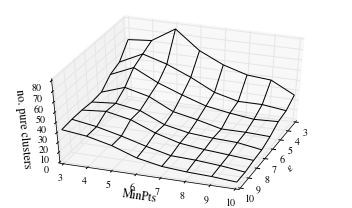

In [513]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')

Xs, Ys = np.meshgrid(epsilons, poins)
# plot surface, more colormaps: http://matplotlib.sourceforge.net/examples/pylab_examples/show_colormaps.html
# ax.plot_surface(Xs, Ys, Zs, rstride=4, cstride=4, alpha=0.4,cmap=cm.jet)

ax.plot_wireframe(Xs, Ys, snn10.unstack(), color='black')
ax.view_init(elev=40, azim=20)
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('MinPts')
ax.set_zlabel('no. pure clusters')

plt.tight_layout()
plt.savefig('figures/nodef-dbscan-jac13.pdf', format='pdf')
plt.show()

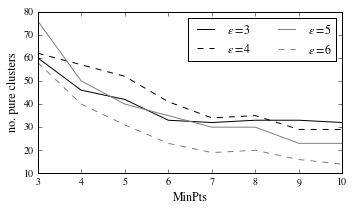

In [514]:
visual = {3: ('black', '-'), 4: ('black', '--'), 5: ('grey', '-'), 6: ('grey', '--')}

for i, n in snn10.reset_index().groupby('eps'):
    if i in visual:
        color, line = visual[i]
        n.set_index('min_pts').no.plot(figsize=(5, 3), color=color, linestyle=line, label=r'$\varepsilon=%d$' % i)

plt.grid(0)
plt.legend(ncol=2)# loc='lower left')
plt.xlabel('MinPts')
plt.ylabel('no. pure clusters')
plt.tight_layout()
plt.savefig('figures/nodef-dbscan-jac13-2.pdf', format='pdf')
plt.show()

In [517]:
clustering = snn_res_j[(10, 3, 3)]
len(evaluate.high_purity_clusters(clustering, threshold=0.8, min_size=3))

87

In [520]:
Counter(clustering)[0]

5581

In [519]:
len(np.unique(clustering))

4219

In [522]:
evaluate.report_overall(clustering, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.3304
number of high purity clusters of size at least 5 is 87

- Continuum mechanics (id=157) size=40, purity=0.8000
- Constellations listed by Ptolemy (id=1812) size=17, purity=1.0000
- National Basketball Association seasons (id=1939) size=13, purity=0.9231
- Statistics (id=3810) size=13, purity=0.8462
- Knot theory (id=4225) size=13, purity=0.8462
- Electromagnetism (id=4106) size=12, purity=0.8333
- Bayer objects (id=3767) size=11, purity=1.0000
- Analytic number theory (id=3644) size=10, purity=0.9000
- Acoustics (id=1706) size=9, purity=0.8889
- Chemical properties (id=2058) size=9, purity=0.8889
- Set theory (id=4176) size=9, purity=0.8889
- Combinatorics (id=2685) size=8, purity=0.8750
- Theory of computation (id=2729) size=8, purity=1.0000
- Partial differential equations (id=3000) size=8, purity=0.8750
- Mathematical logic (id=4165) size=8, purity=0.8750
- Set theory (id=4236) size=8, purity=1.0000
- Fluid mechanics (id=1867) size=7, purity=0.8571
- Dimensiona

In [523]:
evaluate.print_cluster(clustering, 3810)

cluster 3810, size: 13
- Partition of sums of squares (categories: Statistics, Statistical data types, Mathematical optimization, Data analysis, Econometrics, ...) y ESS S_regression p β_0 β_1 ε_i S_error m n β_p S S_total ε T y_i β X TSS RSS
- Deming regression (categories: Statistics, Statistical data types, Mathematical optimization, Data analysis, Econometrics, ...) Z σ η η_i β β_0 β_1 ε_i m s x_i p S R ε δ y_i y x n
- Instrumental variable (categories: Statistics, Fields of application of statistics, Statistical data types, Mathematical and quantitative methods (economics), Mathematical optimization, ...) Pr E_u x_k x_i P_Z β_1 β ε δ y_i z_m noise E P R U T x_1 Y X Z z_1 g f ε_i m p β_k u y x z
- Ordinary least squares (categories: Statistics, Statistical data types, Signal processing, Mathematical optimization, Control theory, ...) Pr w_i x_i n h_j TSS h_i β_1 β_2 β_3 SSR s α β ε y_i σ E η χ M L N Q P S R T x_0 X M_1 c b H_0 h ε_i j y_0 q p β_j X_2 t X_1 y x
- Endogeneity (applie

In [524]:
evaluate.find_identifier(clustering, purity_threshold=0.8, id=u'β', min_size=3, collection_weighting=0)

overall purity 0.3304
number of high purity clusters of size at least 5 is 87

category "Continuum mechanics", cluster_id=157, size=40:
top categories: [(u'Continuum mechanics', 32), (u'Mechanics', 32), (u'Solid mechanics', 27), (u'Materials science', 25), (u'Classical mechanics', 18)]
     β: (bias: 1.75), (criterion: 0.83), (type: 0.83)
category "Radio frequency propagation", cluster_id=623, size=5:
top categories: [(u'Radio frequency propagation', 4), (u'Amateur radio', 4), (u'Radio technology', 4), (u'Wireless', 4), (u'Electromagnetic radiation', 4)]
     β: (clutter factor: 0.95), (kilometer: 0.83)
category "Quantum mechanics", cluster_id=1070, size=3:
top categories: [(u'Quantum mechanics', 3), (u'Theoretical physics', 3), (u'Particle physics', 3), (u'Quantum field theory', 2), (u'Mechanics', 1)]
     β: (voltage-to-barrier-field conversion factor: 1.87), (fowler-nordheim: 0.85), (− value: 0.82)
category "Fluid dynamics", cluster_id=2304, size=5:
top categories: [(u'Fluid dynamic